In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Visualizations will be shown in the notebook.
%matplotlib inline

# Load pickled data
import pickle
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pandas.io.parsers import read_csv


## Loading datasets
file_path = 'train.pickle'
training_file = 'train.pickle'
validation_file='valid.pickle'
testing_file = 'test.pickle'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

sign_names = read_csv("label_names.csv").values[:, 1]

#Separating features and labels
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [7]:
# Number of training examples
n_train = X_train.shape[0]
# Number of validation examples
n_validation = X_valid.shape[0]
# Number of testing examples.
n_test = X_test.shape[0]
# What's the shape of an traffic sign image?
image_shape = X_train[0].shape
# Unique classes/labels there are in the dataset.
classes, class_indices, class_counts  = np.unique(y_train, return_index=True, return_counts=True)
n_classes = len(class_counts)


print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [9]:
from sklearn.utils import shuffle

## Shuffle the dataset
X_train, y_train = shuffle(X_train, y_train)

In [11]:
# Convert RGB images to grayscale for the training set
X_train_gray = np.sum(X_train/3, axis=3, keepdims=True)

# Convert RGB images to grayscale for the testing set
X_test_gray  = np.sum(X_test/3, axis=3, keepdims=True)

# Convert RGB images to grayscale for the validation set
X_validation_gray  = np.sum(X_valid/3, axis=3, keepdims=True)

In [12]:
# Normalize the training set of grayscale images
X_train_gray_norm = (X_train_gray - 32) / 32

# Normalize the test set of grayscale images
X_test_gray_norm = (X_test_gray - 32) / 32

# Normalize the validation set of grayscale images
X_validation_gray_norm = (X_validation_gray - 32) / 32

In [15]:
# Onehot Encoding the labels.
from tensorflow.keras.utils import to_categorical

# Store the original labels for future reference
y_train_unchanged = y_train
y_validation_unchanged = y_valid
y_test_unchanged = y_test

# Perform Onehot Encoding on the labels
# Convert the labels from integer representation to binary matrix representation
y_train = to_categorical(y_train)
y_validation = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [17]:
model = tf.keras.models.load_model('Checkpoint_AlexNet_Epoch_50.h5')
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [19]:
loss, accuracy = model.evaluate(X_test_gray_norm, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - accuracy: 0.8762 - loss: 0.5231
Test Loss: 0.533248782157898
Test Accuracy: 0.8771971464157104


395/395 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step
Original prediction (before FGSM): [16  1 38 33 11 38 18 12 25 35]
True labels: [16  1 38 33 11 38 18 12 25 35]
395/395 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step
Prediction after FGSM attack: [ 7 36 38 36 11 38 18 12  2 12]


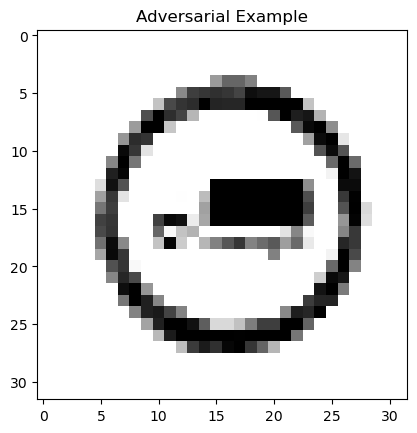

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assuming your model is loaded (replace with your actual model loading code)
# model = tf.keras.models.load_model('your_model.h5')

# Convert your X_test_gray_norm (normalized grayscale images) to a TensorFlow tensor
x_input_all = tf.convert_to_tensor(X_test_gray_norm, dtype=tf.float32)  # Entire dataset
y_input_all = tf.convert_to_tensor(y_test_unchanged, dtype=tf.int32)  # Corresponding labels

# 1. Get the predictions before FGSM
original_predictions = model.predict(x_input_all.numpy())
original_classes = np.argmax(original_predictions, axis=1)

print(f"Original prediction (before FGSM): {original_classes[:10]}")  # Display first 10 predictions
print(f"True labels: {y_input_all.numpy()[:10]}")  # Display first 10 true labels

# Enable GradientTape for automatic differentiation
with tf.GradientTape() as tape:
    tape.watch(x_input_all)  # Watch the input images for gradient computation
    predictions = model(x_input_all)  # Forward pass to get predictions
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_input_all, predictions)  # Compute loss (cross-entropy)

# Compute the gradient of the loss with respect to the input images
gradient = tape.gradient(loss, x_input_all)

# Generate the adversarial examples by applying the sign of the gradient
epsilon = 0.1  # The perturbation magnitude (can adjust)
adversarial_examples = x_input_all + epsilon * tf.sign(gradient)

# Clip the adversarial examples to ensure they are within the valid input range
adversarial_examples = tf.clip_by_value(adversarial_examples, 0, 1)

# 2. Get the predictions on the adversarial examples
adversarial_predictions = model.predict(adversarial_examples.numpy())
adversarial_classes = np.argmax(adversarial_predictions, axis=1)

print(f"Prediction after FGSM attack: {adversarial_classes[:10]}")  # Display first 10 adversarial predictions

# Visualize the first adversarial example
adversarial_example_np = adversarial_examples.numpy()
plt.imshow(adversarial_example_np[0, :, :, 0], cmap='gray')
plt.title("Adversarial Example")
plt.show()


In [35]:
loss, accuracy = model.evaluate(X_test_gray_norm, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - accuracy: 0.8762 - loss: 0.5231
Test Loss: 0.533248782157898
Test Accuracy: 0.8771971464157104


In [37]:
loss, accuracy = model.evaluate(adversarial_examples.numpy(), y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.2614 - loss: 4.0647
Test Loss: 4.058650493621826
Test Accuracy: 0.25787806510925293


In [38]:
X_test_gray_norm.shape

(12630, 32, 32, 1)

In [43]:
adversarial_examples.numpy().shape

(12630, 32, 32, 1)